In [23]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


### Imports

In [45]:
import numpy as np
import cv2
from sklearn.metrics import jaccard_score # for IoU calculation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
import torchvision.transforms.v2 as T

import segmentation_models_pytorch as smp

from introdl.idlmam import train_network
from introdl.utils import get_device, load_model, load_results, config_paths_keys
from introdl.visul import plot_training_metrics

from graphics_and_data_prep import download_pennfudanped, display_images_and_masks, display_iou_illustration

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

MODELS_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models
DATA_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data
TORCH_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads


# Building and Evaluating Semantic Segmenation Models 

In this notebook we'll estimate segmentation masks for pedestrians on a college campus using transfer learning.  This is similar to what a self-driving car would have to do to understand its surroundings.

We'll focus on three things beyond the basics outline in the textbook:
1.  How to augment data for segmenation models.
2.  The Intersection Over Union (IOU) metric for evaluating semantic segmantation model performance. 
3.  The Segmentation-Models-PyTorch package that makes building and testing segmenation models super simple.

## The Dataset

For this example we'll use the [Penn-Fudan Pedestrian dataset](https://www.cis.upenn.edu/~jshi/ped_html/).  It's a small dataset of 170 images with 345 labeled pedestrians.  Labels include bounding boxes and masks. 

You can download the dataset from the link above.  Unzip it in the your DATA_PATH directory.  Alternately you can just run the cell below. (There's no harm in running since it won't do anything if the dataset already exists.)

In [46]:
download_pennfudanped(DATA_PATH)

PennFudanPed dataset already exists.


Here's a sample image and its mask (from the website)

<div style="display: flex; justify-content: center;">
    <img src="pictures/PennPed00018_1.png" alt="Image 1" style="width: 45%; margin-right: 10px;">
    <img src="pictures/PennPed00018_2.png" alt="Image 2" style="width: 45%;">
</div>

A few things to note here.  First, note that first image also displays bounding boxes.  We won't use those for segmention but will use those in another notebook about object detection.  Second, notice that the mask uses different colors for each pedestrian.  This would be important in *instance segmentation* where we would be trying to distinguish between various instances of the same class.  Instance segmentation is harder than the *semantic segmentation* we're doing here.  In our problem we try to classify every pixel in the image as either background or pedestrian.  Third, notice that the third pededestrian who is tucked behind the second isn't included in the mask.  Most segmentation models won't be able to distinguish between the second and third pedestrian.

In our custom dataset class in the next section, we'll convert the provided masks into binary masks so that all background pixels are labeled as 0 and the pedestrian pixels are labeled as one.  For example the binary mask correspond to the above images would be:

<img src="pictures/PennPed00018_binary_mask.png" alt="Binary Mask" style="width: 400px;">

## Preparing the Data for Training and Evaluation

The PennFudan Pedestrian dataset is not built-in to Torchvision so we'll need to implement a custom Dataset class.  We want the class to
* split the data into training (80%) and validation (20%) sets
* combine the multiple pedestrians masks into a single binary mask for each image
* convert the images and masks to torchvision tv_tensors to be used with torchvision.tranforms.v2
* apply any transforms as we fetch images and masks from the dataset 

An AI like ChatGPT is really helpful for generating code like this.  Start with a prompt something like this: "write a custom pytorch dataset class that prepares PennFudan images and masks for segmentation, pass in split = 'train' or 'val', v2 transforms, the data root directory, and a seed for reproducibility of the 80/20 split.  Convert the masks and images to tv_tensors before applying the transforms.  since the dataset is small, load it all into the dataset when it is instantiated."  At the very least, that prompt will get you a good starting point for the code.  It may even build a perfectly usable class.

Below is the code for the custom dataset and a video walkthrough explaining the code.  

INSERT VIDEO HERE

In [47]:
class PennFudanSegment(Dataset):
    """
    A custom Dataset class for loading and processing the Penn-Fudan Pedestrian Segmentation dataset.

    Args:
        root (str or Path): Root directory of the dataset.
        transforms (callable, optional): A function/transform that takes in an image and a mask and returns a transformed version.
        split (str, optional): The dataset split to use, either 'train' or 'val'. Default is 'train'.
        seed (int, optional): Random seed for reproducibility. Default is 42.

    Attributes:
        root (Path): Path object for the root directory.
        transforms (callable): Transform function.
        imgs (list): List of image file paths for the selected split.
        masks (list): List of combined mask tensors for the selected split.

    Methods:
        __getitem__(idx):
            Returns the image and mask at the specified index after applying transformations.

        __len__():
            Returns the number of samples in the dataset.
    """
    def __init__(self, root, transforms=None, split='train', test_size=0.2, seed=42):
        self.root = Path(root)
        self.transforms = transforms

        # Load all image and mask files
        all_imgs = sorted((self.root / "PNGImages").iterdir())
        all_masks = sorted((self.root / "PedMasks").iterdir())

        # Ensure that the number of images and masks are the same
        assert len(all_imgs) == len(all_masks), "The number of images and masks must be the same"

        # Split the indices into train and validation sets
        indices = list(range(len(all_imgs)))
        train_indices, val_indices = train_test_split(indices, test_size=test_size, random_state=seed)

        # Select the appropriate indices based on the split
        if split == 'train':
            selected_indices = train_indices
        elif split == 'val':
            selected_indices = val_indices
        else:
            raise ValueError("Split must be 'train' or 'val'")

        # Filter images and create combined masks for selected indices
        self.data = []
        for i in selected_indices:
            img = read_image(str(all_imgs[i])).float() / 255.0  # Ensure float type and normalize to [0, 1]
            mask = read_image(str(all_masks[i]))
            mask = (mask > 0).float() # Combine all instance masks into one binary mask with float values
            self.data.append((tv_tensors.Image(img), tv_tensors.Mask(mask))) # convert to torchvision datapoints

    def __getitem__(self, idx):
        # Load image and mask
        img, mask = self.data[idx]

        # Apply transformations
        if self.transforms is not None:
            img, mask = self.transforms(img, mask)

        return img, mask

    def __len__(self):
        return len(self.data)


To train the model we'll need DataLoaders for the training and validation sets.  We wrapped the transforms and loaders in a function for convenience so we can later experiment with changing the image size to preserve more detail in the images.

In [48]:
def get_datasets_and_loaders(size=224, bs=8, nw = 2):

    # Define training transformations
    train_transforms = T.Compose([
        T.Resize((size, size)),  # Resize to size x size
        T.RandomHorizontalFlip(0.5),  # Random horizontal flip with 50% probability
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color jitter
        T.RandomRotation(degrees=(-10, 10)),  # Random rotation within +/- 10 degrees
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
        T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
    ])

    # Define validation transformations (no data augmentation, just tensor conversion)
    val_transforms = T.Compose([
        T.Resize((size, size)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
    ])

    # Usage with the dataset
    dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
    train_dataset = PennFudanSegment(root=dataset_path, transforms=train_transforms, split='train')
    val_dataset = PennFudanSegment(root=dataset_path, transforms=val_transforms, split='val')

    # Define training and validation data loaders
    train_loader = DataLoader(train_dataset,batch_size=bs,shuffle=True, num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=bs,shuffle=False, num_workers=nw)

    return train_dataset, val_dataset, train_loader, val_loader

train_dataset, val_dataset, train_loader, val_loader = get_datasets_and_loaders()

In [49]:
images,masks = next(iter(train_loader))

RuntimeError: DataLoader worker (pid(s) 37516, 32700) exited unexpectedly

Here are a few images from the validation set along with their masks.  We can plot the images and masks side-by-side.

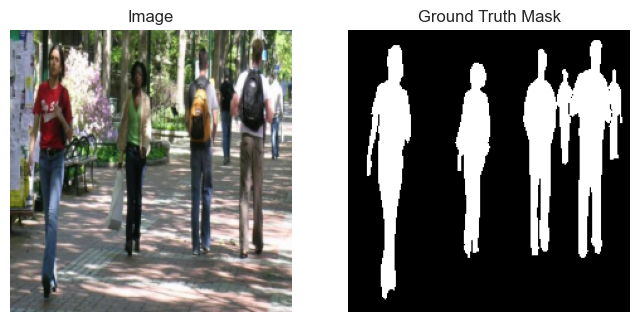

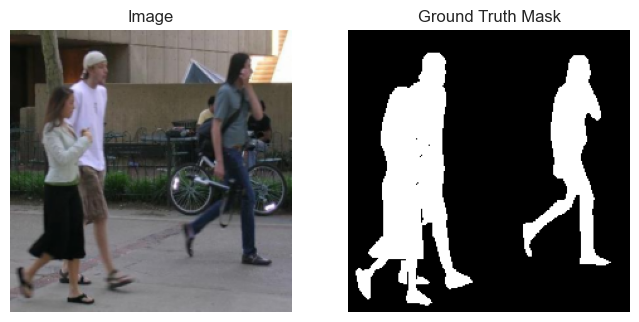

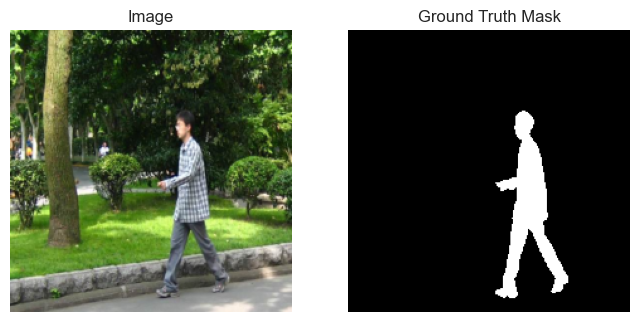

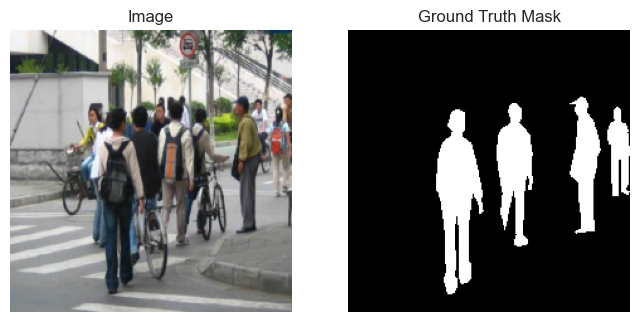

In [28]:
selected_images = [4,0,1,13]
display_images_and_masks(val_dataset, overlay=False, indices=selected_images, denormalize=True)

Or we can plot the masks as outlines on top of the original image.

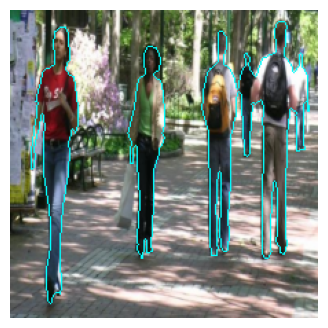

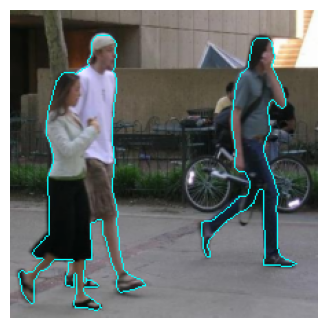

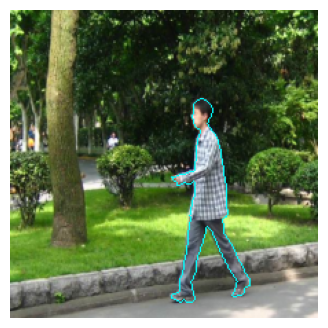

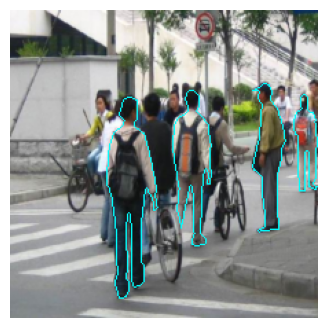

In [29]:
display_images_and_masks(val_dataset, overlay=True, indices=selected_images, denormalize=True)

## Evaluating the performance of a segmentation model

In the context of binary segmentation, the following terms are used to evaluate the performance of a segmentation model:

- **True Positives (TP)**: Pixels correctly predicted as the target class (e.g., pedestrian).
- **False Positives (FP)**: Pixels incorrectly predicted as the target class (should be background).
- **False Negatives (FN)**: Pixels incorrectly predicted as background (should be the target class).
- **True Negatives (TN)**: Pixels correctly predicted as background.

These metrics are used to calculate various performance measures such as Precision, Recall, Dice Coefficient, and Intersection over Union (IoU).

1. **Intersection over Union (IoU, Jaccard Index)**:
    - **Formula**: 
      $$\text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}} = \frac{\text{Pixels in intersection of masks}}{\text{Pixels in union of masks}}$$
    - **Description**: IoU measures the overlap between the predicted segmentation mask and the ground truth mask. It is the ratio of the intersection of the predicted and ground truth masks to their union.

2. **Dice Coefficient (F1-Score for Segmentation)**:
    - **Formula**: 
      $$\text{Dice} = \frac{2 \times \text{TP}}{2 \times \text{TP} + \text{FP} + \text{FN}} = \frac{2 \times \text{Pixels in intersection of masks}}{\text{Pixels in predicted mask} + \text{Pixels in ground truth mask}}$$
    - **Description**: The Dice Coefficient is similar to the F1-Score but is specifically used for segmentation tasks. It measures the overlap between the predicted and ground truth masks, emphasizing the intersection area.

3. **Recall (Sensitivity, True Positive Rate)**:
    - **Formula**: 
      $$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{Pixels correctly predicted as target class}}{\text{Pixels in ground truth mask}}$$
        - **Description**: Recall measures the proportion of pixels in the ground truth mask that are correctly predicted. It indicates how many of the actual target class pixels are correctly identified by the model.

4. **Precision (Positive Predictive Value)**:
    - **Formula**: 
      $$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{\text{Pixels correctly predicted as target class}}{\text{Pixels in predicted mask}}$$
    - **Description**: Precision measures the proportion of pixels in the predected mask that are correctly predicted. It indicates how many of the predicted target class pixels are actually target class pixels.

5. **Accuracy**:
    - **Formula**: 
      $$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} = \frac{\text{Correctly predicted pixels}}{\text{Total number of pixels}}$$
    - **Description**: Accuracy measures the proportion of correctly predicted pixels (both target class and background) among all pixels. It indicates the overall correctness of the model's predictions.
    

The two main metrics that are used in object segmenation are IoU and the Dice Coefficient.  Which one to use depends on the context.

### **Practical Considerations**

| **Aspect**               | **Dice Coefficient**                      | **IoU**                              |
|--------------------------|-------------------------------------------|--------------------------------------|
| **Sensitivity to overlap**| More sensitive to small overlaps          | Less sensitive to small overlaps     |
| **Penalty for overprediction** | Weaker penalty for overprediction         | Stronger penalty for overprediction  |
| **Use case**             | Medical imaging, applications emphasizing accurate overlap | Object detection, general-purpose segmentation |
| **Optimization**         | Easier to optimize                       | Harder to optimize                   |
| **Interpretation**       | Higher overlap sensitivity, good for reporting in certain domains | Easier to relate to bounding box tasks |


### **Which to Use?**

- **Dice**: When sensitivity to small objects or fine-grained overlap is important (e.g., medical imaging, biological segmentation tasks).
- **IoU**: When penalizing overprediction is critical or for use in standard object detection benchmarks.

In [30]:
display_iou_illustration(1,val_dataset)

interactive(children=(FloatSlider(value=0.0, description='Quality', layout=Layout(width='500px'), max=1.0, ste…

## Configuring and Training a Model

We'll use the [Segmentation Models PyTorch package](https://github.com/qubvel-org/segmentation_models.pytorch?tab=readme-ov-file) to create a segmentation model.  Its high-level API makes it easy to create multiple segmentation architectures that use many different pretrained backbone networks.

In the example below we configure a UNet with a ResNet34 backbone.  UNets are described in the text, but here is a brief summary of how one works with a pretrained backbone model.

A UNet is a type of convolutional neural network (CNN) designed for image segmentation tasks. It consists of two main parts: the encoder (contracting path) and the decoder (expanding path). Here's a brief description of how a UNet is built using a CNN as a backbone:

1. **Encoder (Contracting Path)**:
   - The encoder is typically a pre-trained CNN (e.g., ResNet101) that extracts features from the input image.
   - It consists of a series of convolutional layers followed by activation functions (e.g., ReLU) and pooling layers (e.g., max pooling) to reduce the spatial dimensions while increasing the depth of feature maps.
   - The encoder captures the context and high-level features of the image.

2. **Bottleneck**:
   - The bottleneck is the transition between the encoder and decoder. It consists of convolutional layers that further process the features extracted by the encoder.

3. **Decoder (Expanding Path)**:
   - The decoder upsamples the feature maps to reconstruct the spatial dimensions of the original image.
   - It consists of upsampling layers (e.g., transposed convolutions) followed by convolutional layers.
   - Skip connections from the encoder to the decoder are used to combine high-resolution features from the encoder with the upsampled features in the decoder. This helps in preserving spatial information and improving segmentation accuracy.

4. **Output Layer**:
   - The final layer of the UNet is a convolutional layer that produces the segmentation map, typically with a softmax or sigmoid activation function to output class probabilities for each pixel.

By using a pre-trained CNN as the backbone for the encoder, the UNet leverages the powerful feature extraction capabilities of the CNN, which can improve the performance of the segmentation model.

In [31]:
# Set up the U-Net model
model = smp.Unet(
    encoder_name='resnet34',      # Use ResNet-34 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

device = get_device()

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation
optimizer = optim.AdamW(model.parameters(), lr=0.001)

score_funcs = {"IOU": jaccard_score}

num_epochs = 2
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_b.pth"
results = train_network(model, 
                        loss_fn,
                        train_loader, 
                        optimizer=optimizer,
                        val_loader=val_loader, 
                        device=device, 
                        checkpoint_file=checkpoint_file,
                        epochs=num_epochs,
                        early_stop_metric="IOU",
                        early_stop_crit="max",
                        patience=5,
                        score_funcs=score_funcs,
                        pretend_train=True)

# change pretend_train to False to train the model

Pretend Training:   0%|          | 0/20 [00:00<?, ?it/s]

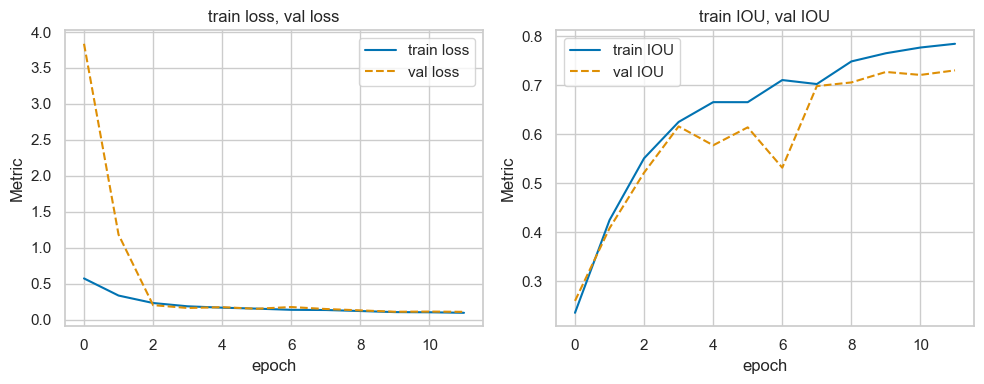

In [32]:
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan.pth"
results = load_results(checkpoint_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train IOU', 'val IOU']])

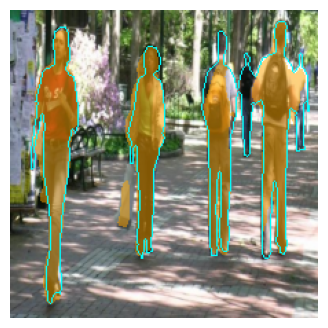

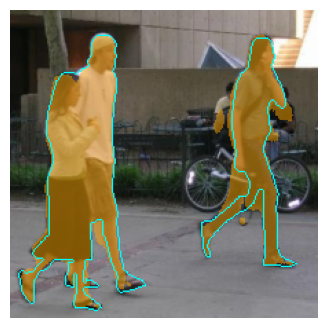

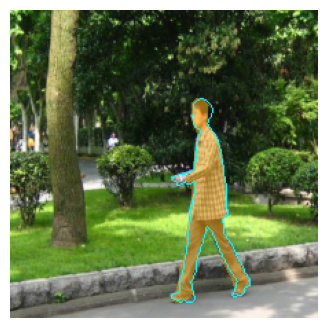

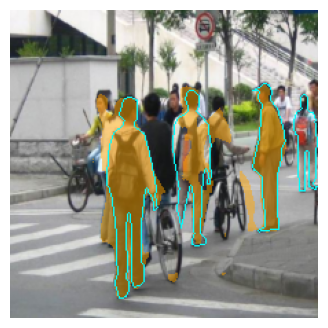

In [33]:
model = smp.Unet(
    encoder_name="resnet34",       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)


checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan.pth"
model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True, mode='shaded', alpha=0.5)

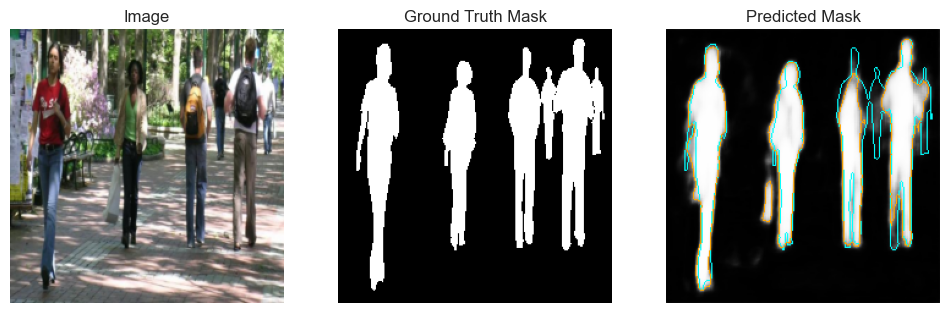

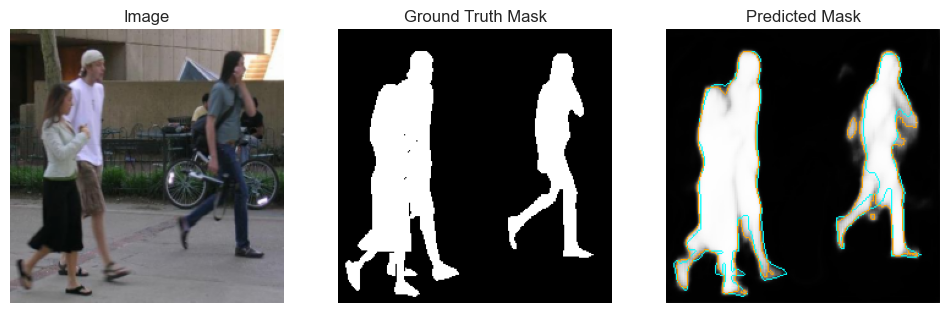

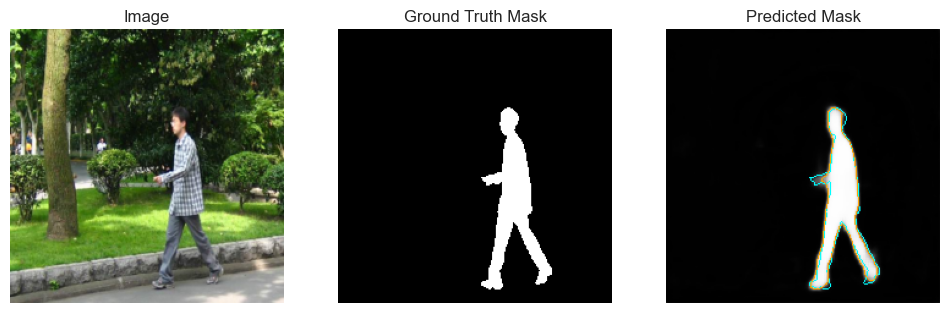

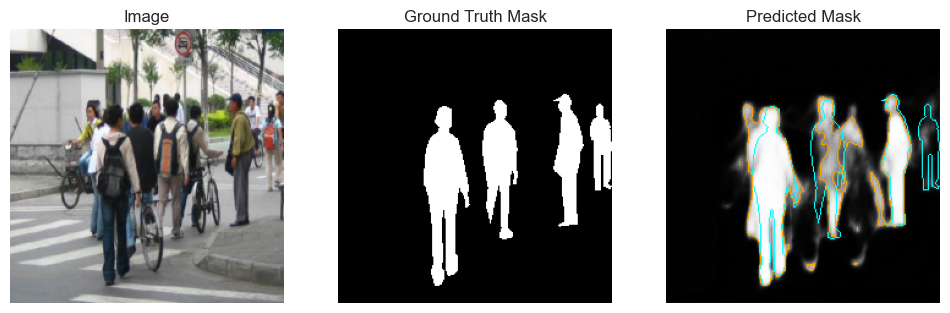

In [34]:
display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=False)

### Better Training 

There are a couple of things we can do to improve the training of our UNet model.  First, we can use a lower learning rate for the pretrained backbone in the encoder part of the internet.  The backbone is pre-trained on ImageNet so we want to maintain its ability to extract good features by not changing it as much as the decoder.  Second, we can use OneCycleLR to improve performance and perhaps reduce overfitting.  We show how to do both of these things below.

In [35]:
# Set up the U-Net model
model = smp.Unet(
    encoder_name='resnet34',      # Use ResNet-34 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

device = get_device()

# Separate parameters into groups
encoder_params = list(model.encoder.parameters())  # Pretrained encoder (backbone)
decoder_params = list(model.decoder.parameters())  # Decoder (newly initialized layers)

# Define optimizer with different learning rates for backbone and decoder
optimizer = optim.AdamW([
    {"params": encoder_params, "lr": 1e-4},  # Lower learning rate for the backbone
    {"params": decoder_params, "lr": 1e-3},  # Higher learning rate for the decoder
])

# Define loss function
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation

# Define score function(s)
score_funcs = {"IOU": jaccard_score}

# Define learning rate scheduler with OneCycleLR
num_epochs = 20
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,  # Max LR for OneCycleLR (applies to highest LR group, i.e., decoder)
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

# Train the model
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_onecycle.pth"
results = train_network(
    model,
    loss_fn,
    train_loader,
    optimizer=optimizer,
    val_loader=val_loader,
    device=device,
    checkpoint_file=checkpoint_file,
    epochs=num_epochs,
    lr_schedule=scheduler,  # Pass the scheduler to the training loop
    early_stop_metric="IOU",
    early_stop_crit="max",
    patience=5,
    score_funcs=score_funcs,
    scheduler_step_per_batch=True,
    pretend_train=True
)

Pretend Training:   0%|          | 0/20 [00:00<?, ?it/s]

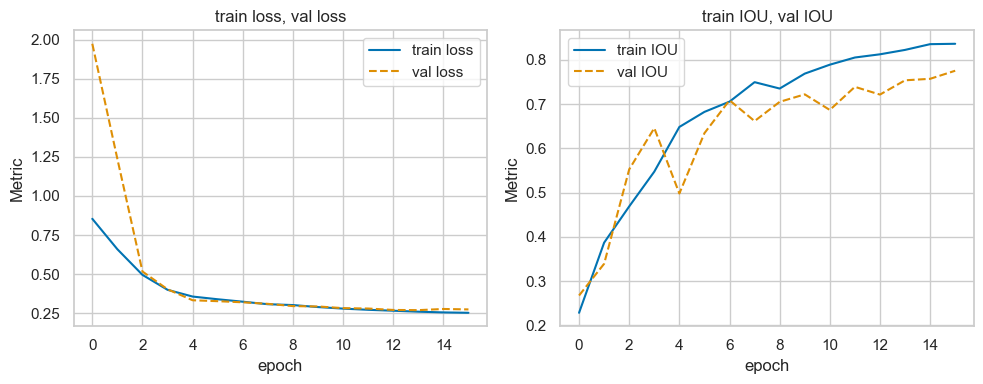

In [36]:
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_onecycle.pth"
results = load_results(checkpoint_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train IOU', 'val IOU']])

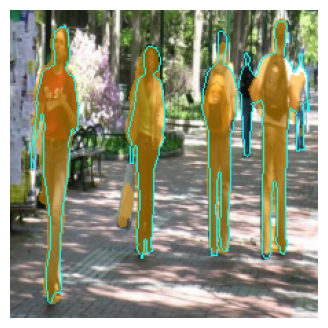

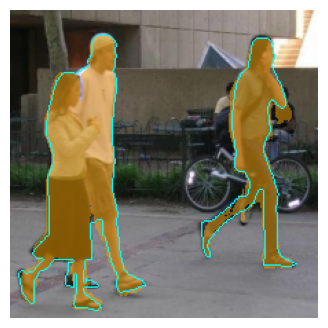

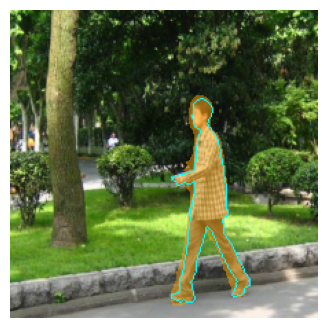

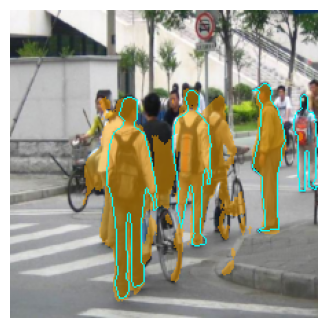

In [37]:
model = smp.Unet(
    encoder_name="resnet34",       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)


checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_onecycle.pth"
model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True, mode='shaded', alpha=0.5)

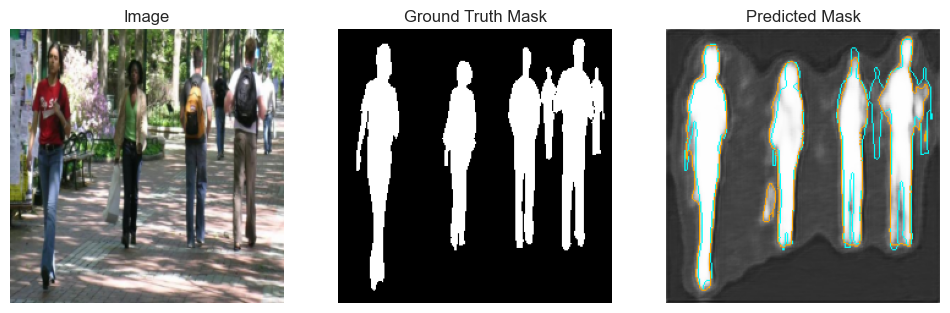

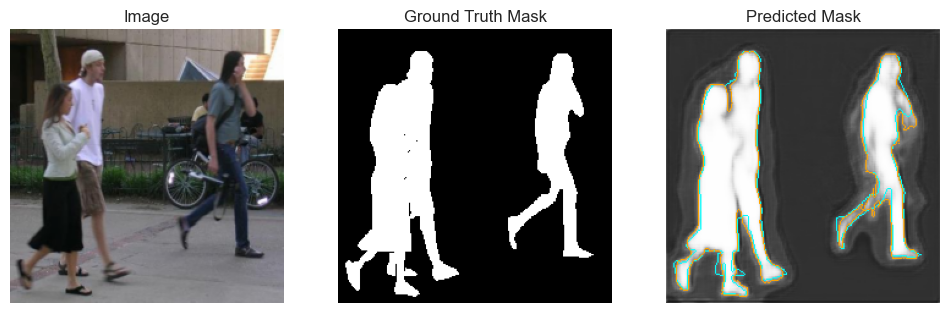

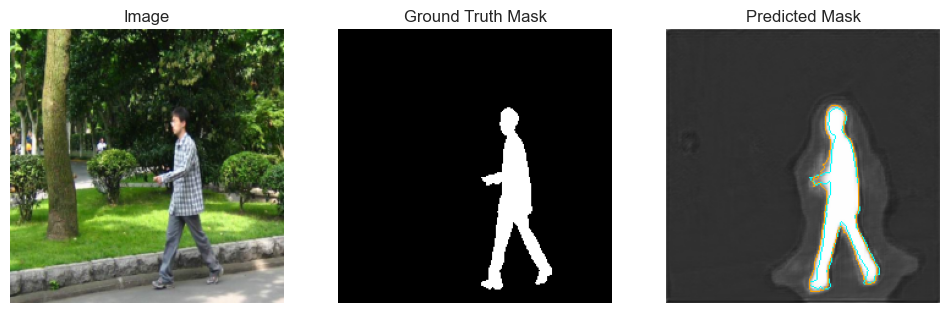

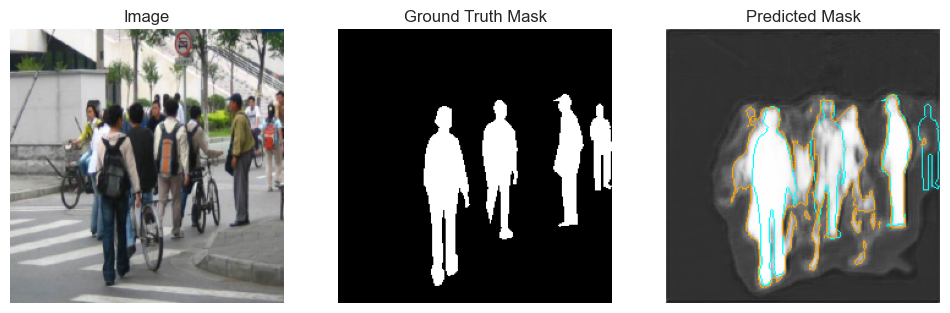

In [38]:
display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=False)

### Higher Resolution Images

The images in the PennFudan Pedestrian dataset typically have dimensions greater than 224x224 with many having 500 or 600 pixels per side.  By downsizing the images to 224x224 we're throwing away details that may be useful.  For such a small dataset we can afford to train at a higher resolution so we'll try 512x512 which is a standard size used by many segmentation models.  This takes eight minutes to train a good gaming GPU, so you may not want to try the training yourself.  (Use `pretend_train=True`)

In [39]:
# get new loaders at the larger size
train_dataset, val_dataset, train_loader, val_loader = get_datasets_and_loaders(size=512)

# Set up the U-Net model
model = smp.Unet(
    encoder_name='resnet34',      # Use ResNet-34 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

device = get_device()

# Separate parameters into groups
encoder_params = list(model.encoder.parameters())  # Pretrained encoder (backbone)
decoder_params = list(model.decoder.parameters())  # Decoder (newly initialized layers)

# Define optimizer with different learning rates for backbone and decoder
optimizer = optim.AdamW([
    {"params": encoder_params, "lr": 1e-4},  # Lower learning rate for the backbone
    {"params": decoder_params, "lr": 1e-3},  # Higher learning rate for the decoder
])

# Define loss function
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation

# Define score function(s)
score_funcs = {"IOU": jaccard_score}

# Define learning rate scheduler with OneCycleLR
num_epochs = 20
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,  # Max LR for OneCycleLR (applies to highest LR group, i.e., decoder)
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

# Train the model
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_onecycle_512.pth"
results = train_network(
    model,
    loss_fn,
    train_loader,
    optimizer=optimizer,
    val_loader=val_loader,
    device=device,
    checkpoint_file=checkpoint_file,
    epochs=num_epochs,
    lr_schedule=scheduler,  # Pass the scheduler to the training loop
    early_stop_metric="IOU",
    early_stop_crit="max",
    patience=5,
    score_funcs=score_funcs,
    scheduler_step_per_batch=True,
    pretend_train=True
)


Pretend Training:   0%|          | 0/20 [00:00<?, ?it/s]

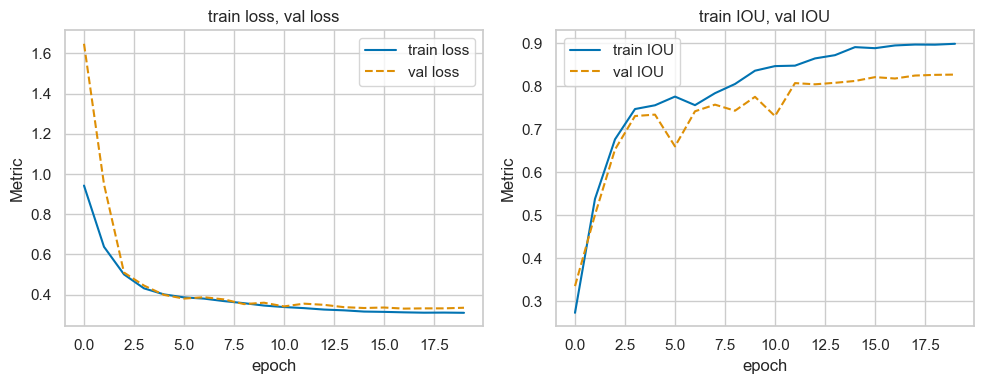

In [40]:
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_onecycle_512.pth"
results = load_results(checkpoint_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train IOU', 'val IOU']])
model = smp.Unet(
    encoder_name="resnet34",       # Use ResNet-18 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

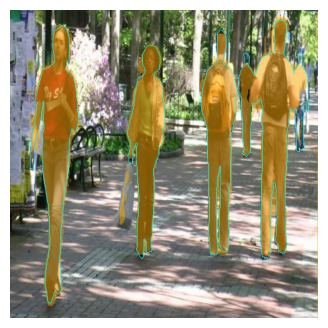

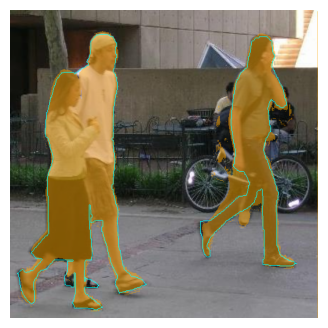

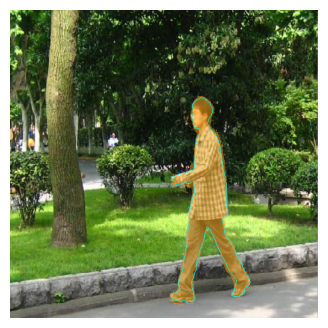

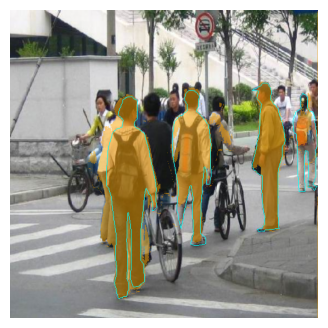

In [41]:
checkpoint_file = MODELS_PATH / "L06_unet_resnet34_pennfudan_onecycle_512.pth"
model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True, mode='shaded', alpha=0.5)

## DeepLabv3+

Just to illustrate, we show how you can train other segmentation models using the Segmentation Models Pytorch package. In this case we'll train [Google's DeepLabv3+](https://arxiv.org/abs/1802.02611). 

In [42]:
# reset loaders to 224x224
train_dataset, val_dataset, train_loader, val_loader = get_datasets_and_loaders(size=224)

# Set up the DeepLabV3+ model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # Use ResNet-34 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

device = get_device()

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for binary segmentation
optimizer = optim.AdamW(model.parameters(), lr=0.001)

score_funcs = {"IOU": jaccard_score}

checkpoint_file = MODELS_PATH / "L06_deeplabv3plus_resnet34_pennfudan.pth"

# Train the model
num_epochs = 20
results = train_network(model, 
                        loss_fn,
                        train_loader, 
                        optimizer=optimizer,
                        val_loader=val_loader, 
                        device=device, 
                        checkpoint_file=checkpoint_file,
                        epochs=num_epochs,
                        early_stop_metric="IOU",
                        early_stop_crit="max",
                        patience=5,
                        score_funcs=score_funcs,
                        pretend_train=True)


Pretend Training:   0%|          | 0/20 [00:00<?, ?it/s]

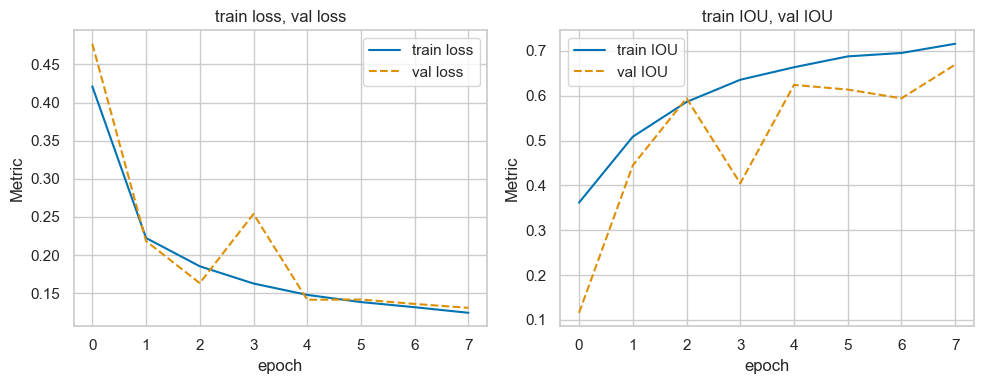

In [43]:
checkpoint_file = MODELS_PATH / "L06_deeplabv3plus_resnet34_pennfudan.pth"
results = load_results(checkpoint_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train IOU', 'val IOU']])


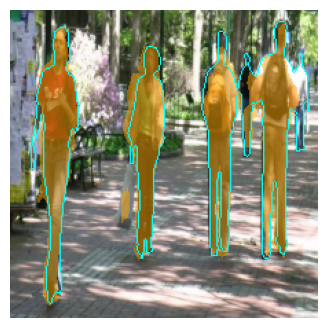

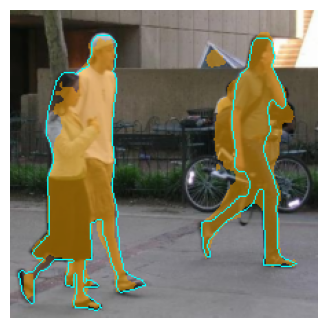

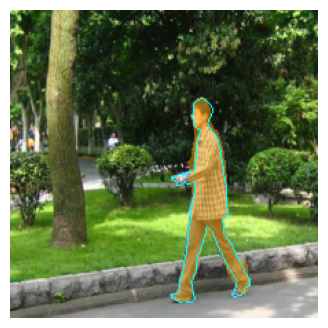

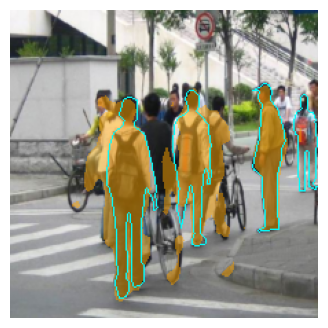

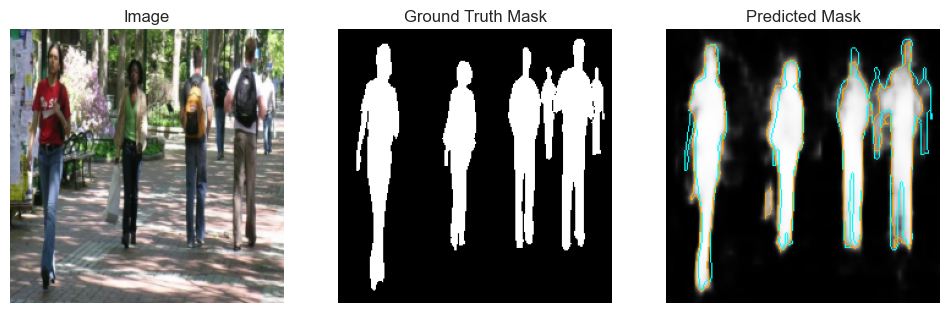

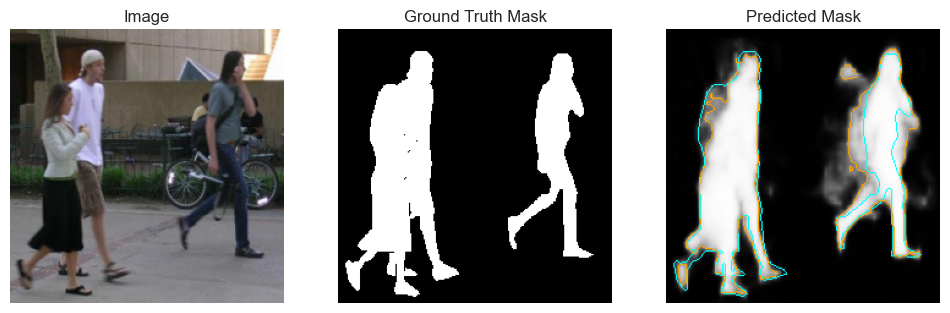

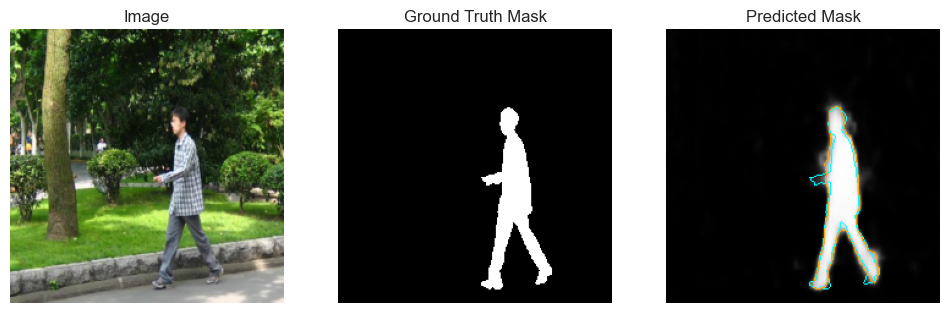

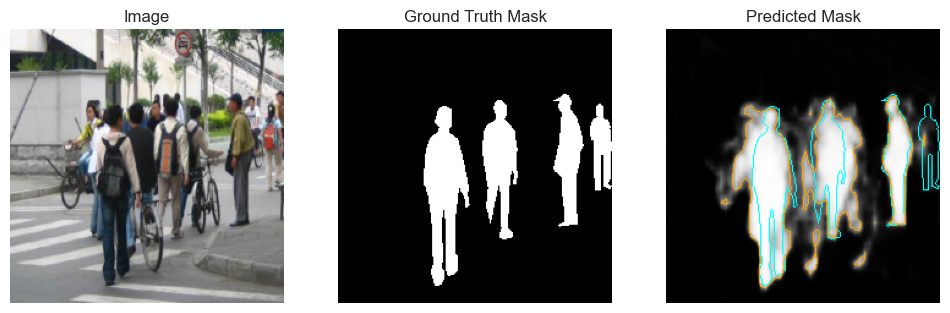

In [44]:
checkpoint_file = MODELS_PATH / "L06_deeplabv3plus_resnet34_pennfudan.pth"

# Set up the DeepLabV3+ model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # Use ResNet-34 as the encoder
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Input has 3 channels (RGB)
    classes=1                      # Output has 1 channel for binary segmentation
)

model = load_model(model, checkpoint_file)
device = get_device()
model = model.to(device)

display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=True, mode="shaded",alpha=0.5)
display_images_and_masks(val_dataset, model=model, denormalize=True, indices=selected_images, overlay=False)